In [1]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Parametrized images vs true information (TRAINING)

This notebook uses data generated via ``protopipe.scripts.data_training`` with the option ``--save_images`` (from the GRID interface due to the amount of data), so we use store information of the **simulated** images together with the **reconstructed** ones.

It can be run from any training run data file, but it is meant to be executed using data from the gamma-1 sample, aka the one used to train the energy model.

**Warning:**

The merged data training file from the gamma-1 sample **with** true images can be as heavy as ~80Gb!

Here only 10 following runs have been merged into 1 table, which is then a sub-sample of gamma1:

- TRAINING_energy_gamma_tail_10runs.h5
- TRAINING_energy_gamma_tail_run101.h5
- TRAINING_energy_gamma_tail_run102.h5
- TRAINING_energy_gamma_tail_run103.h5
- TRAINING_energy_gamma_tail_run104.h5
- TRAINING_energy_gamma_tail_run105.h5
- TRAINING_energy_gamma_tail_run106.h5
- TRAINING_energy_gamma_tail_run107.h5
- TRAINING_energy_gamma_tail_run108.h5
- TRAINING_energy_gamma_tail_run109.h5
- TRAINING_energy_gamma_tail_run10.h5

**TODO(s):**

- Comparison between reconstructed and true parameters


## Table of contents
  - [Total image charge ("Intensity") resolution for selected images](#Total-image-charge-("Intensity")-resolution-for-selected-images)
      - [Distributions](#Distributions)
      - [Mean and RMS as error bar of intensity profile](#Mean-and-RMS-as-error-bar-of-intensity-profile)
      - [RMS/Mean](#RMS/Mean)

## Imports

In [1]:
import os
import numpy as np
from scipy.stats import binned_statistic
import tables
import pandas
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## Functions

In [2]:
def get_camera_names(inputPath = None, fileName = None):
    """Read the names of the cameras.
    
    Parameters
    ==========
    infile : str
        Full path of the input DL1 file.
    fileName : str
        Name of the input DL1 file.
    
    Returns
    =======
    camera_names : list(str)
        Table names as a list.
    """
    if (inputPath is None) or (fileName is None):
        print("ERROR: check input")
    h5file = tables.open_file(os.path.join(inputPath, fileName), mode='r')
    group = h5file.get_node("/")
    camera_names = [x.name for x in group._f_list_nodes()]
    h5file.close()
    return camera_names

In [3]:
def load_reset_infile_protopipe(inputPath = None, fileName = None, camera_names=None):
    """(Re)load the file containing DL1(a) data and extract the data per telescope type.
     
    Parameters
    ==========
    infile : str
        Full path of the input DL1 file.
    fileName : str
        Name of the input DL1 file.
    
    Returns
    =======
    dataFrames : dict(pandas.DataFrame)
        Dictionary of tables per camera.
    """
    if (inputPath is None) or (fileName is None):
        print("ERROR: check input")
    if camera_names is None:
        print("ERROR: no cameras specified")
    # load DL1 images
    dataFrames = {camera : pandas.read_hdf(os.path.join(inputPath, fileName), f"/{camera}") for camera in camera_names}
    return dataFrames

In [4]:
indir = "/Volumes/DataCEA_PERESANO/Data/CTA/shared_folder/analyses/v0.4.0_dev1_only_gamma1_with_images/data/TRAINING/for_energy_estimation"
#infile = "TRAINING_energy_tail_gamma_merged.h5"
infile = "TRAINING_energy_gamma_tail_10runs.h5"
filepath = os.path.join(indir, infile)

In [5]:
cameras = get_camera_names(inputPath = indir,
                                   fileName = infile)

In [6]:
h5file = tables.open_file(os.path.join(indir, infile), mode='r')
data = {camera : h5file.get_node(f"/{camera}") for camera in cameras}

In [7]:
# select only images with cut in
# - Intensity>50 (in the "biased" units)
# - 80% camera radius containment (defined as 2.31 deg for LST, 4.05 deg for NectarCam)
# - maximum impact parameter of 200 m
selected_images = {}
for camera in cameras:
    cam_radius_deg = {"LSTCam" : 2.31, "NectarCam" : 4.05}
    selected_images[camera] = data[camera][(data[camera].col("hillas_intensity_reco")>50.) & 
                                           (data[camera].col("hillas_r")<0.8*cam_radius_deg[camera]) &
                                           (data[camera].col("impact_dist")<200.)]

In [8]:
tot_true_phe = {}
hillas_intensity_reco = {}

for camera in cameras:
    tot_true_phe[camera] = np.sum(selected_images[camera]["true_image"], axis=1)
    hillas_intensity_reco[camera] = selected_images[camera]["hillas_intensity_reco"]

## Total image charge ("Intensity") resolution for selected images
[back to top](#Table-of-contents)

This benchmark shows how well the total reconstructed charge in pixels surviving image cleaning (intensity) correlates with the true number of photoelectrons from Cherenkov photons in the **whole** camera.  
This correlation is relevant, above all, for the energy reconstruction.

The data used needs to be TRAINING data from the gamma-1 sample selected with the following cuts:
- intensity > 50 phe (in the "biased" units from the calibration notebook)
- 80% camera radius containment (defined as 2.31 deg for LST, 4.05 deg for NectarCam)
- maximum impact parameter of 200 m

### Distributions
[back to top](#Table-of-contents)

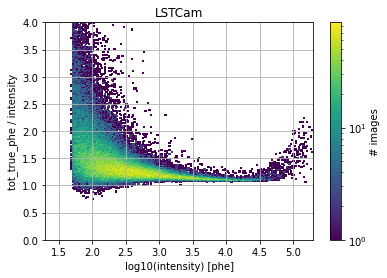

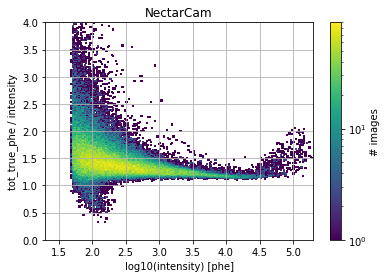

In [9]:
nbins_x_edges = np.linspace(1.298, 5.298, 200)
nbins_y__edges = np.linspace(0., 4., 200)

for camera in cameras:
    
    plt.figure()

    plt.hist2d(x = np.log10(hillas_intensity_reco[camera]), 
               y = tot_true_phe[camera] / hillas_intensity_reco[camera], 
               bins=[nbins_x_edges,nbins_y__edges], 
               #range=[x_range,y_range],
               norm=LogNorm()
              )
    
    cbar = plt.colorbar()
    cbar.set_label("# images")
    
    plt.title(camera)
    plt.xlabel("log10(intensity) [phe]")
    plt.ylabel("tot_true_phe / intensity")
    
    plt.grid(which="both", axis="both")
    
    #plt.savefig(f"./correlation_intensity_trueCharge_ditribution_{camera}_protopipe_dev.png")
    
None

### Mean and RMS as error bar of intensity profile
[back to top](#Table-of-contents)

In [10]:
profiled_mean = {}
profiled_std = {}

# x-axis edges from CTAMARS reference file named "check_dl1b.root"
bins = np.array([1.298, 1.498, 1.698, 1.898, 2.098, 2.298, 2.498, 2.698, 2.898,
       3.098, 3.298, 3.498, 3.698, 3.898, 4.098, 4.298, 4.498, 4.698,
       4.898, 5.098, 5.298])

for camera in cameras:
    profiled_mean[camera], x_edges, xbinnumber = binned_statistic(x = np.log10(hillas_intensity_reco[camera]),
                                                 values = tot_true_phe[camera] / hillas_intensity_reco[camera],
                                                 statistic='mean',
                                                 bins=bins)
    profiled_std[camera], x_edges, xbinnumber = binned_statistic(x = np.log10(hillas_intensity_reco[camera]),
                                                 values = tot_true_phe[camera] / hillas_intensity_reco[camera],
                                                 statistic='std',
                                                 bins=bins)

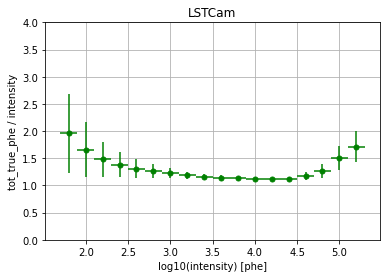

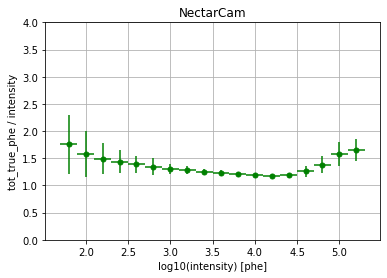

In [11]:
for camera in cameras:
    
    plt.figure()
    
    plt.errorbar(x = 0.5 * (x_edges[1:] + x_edges[:-1]), 
                 y = profiled_mean[camera], 
                 yerr=profiled_std[camera], 
                 xerr=np.diff(x_edges)/2.,
                 fmt='go',
                 ecolor="g",
                 markersize=5)
    
    
    plt.title(camera)
    plt.ylim(0.,4.)
    plt.xlabel("log10(intensity) [phe]")
    plt.ylabel("tot_true_phe / intensity")
    
    plt.grid(which="both", axis="both")
    
    #plt.savefig(f"./correlation_intensity_trueCharge_mean+RMSerrorbar_{camera}_protopipe_dev.png")
    

### RMS/Mean
[back to top](#Table-of-contents)

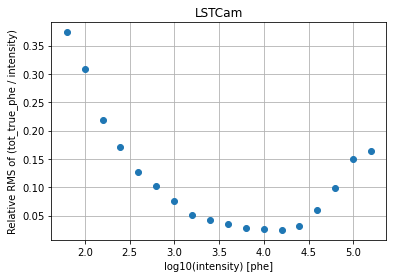

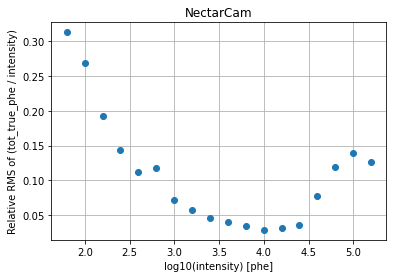

In [12]:
for camera in cameras:
    
    plt.figure()
    
    plt.plot(0.5 * (x_edges[1:] + x_edges[:-1]), profiled_std[camera]/profiled_mean[camera], 'o')
    
    
    plt.title(camera)
    plt.xlabel("log10(intensity) [phe]")
    plt.ylabel("Relative RMS of (tot_true_phe / intensity)")
    
    plt.grid(which="both", axis="both")
    
    #plt.savefig(f"./correlation_intensity_trueCharge_meanRMSratio_{camera}_protopipe_dev.png")
    